### Uncertainty Tutorial | Model Profiling | LeNet

#### Step 1 - Import relevant modules

In [29]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision.transforms.functional as TF
torch.cuda.set_device(1)
from torchsummary import summary
from untangle import UntangleAI
untangle_ai = UntangleAI()

#### Step 2 - Define transforms to be applied to each input image

In [30]:
class MyContrastTransform:

    def __init__(self):
        pass

    def __call__(self, x):
        return TF.adjust_contrast(x, 5)

class MyNegativeTransform:
    
    def __init__(self):
        pass
    
    def __call__(self,x):
        return torch.ones(x.shape)-x

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Step 3 (optional) - Display input samples

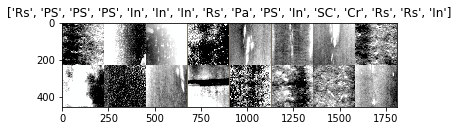

In [31]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Step 4 - Define the pytorch model

In [33]:
from collections import OrderedDict
class Modified_LeNet5(nn.Module):
    def __init__(self):
        super(Modified_LeNet5, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(3, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120*49*49,84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 6)),
        ]))
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

#### Step 5 - Define uncertainty arguments and set the module to eval phase

In [35]:
class Args:
    mname = 'lenet_neu'
    batch_size = 128
    num_classes = 6
    img_size = (3,224,224)
    input_tensor = torch.randn(1,3,224,224) # provide your own input tensor
    data_class = None # or `None` to model uncertainty for all classes
    mode = 'eval_point' # one of `model`, `eval_point`, `rank`
    metric = 'prob' # for future additions. Current default set to `prob`
    sigmoid_node = False # if True, model is assumed to have a single output node with Sigmoid

args = Args()
model_ft = Modified_LeNet5()
model_ft = model_ft.eval()
keys = [str(item) for item in range(args.num_classes)]
ID2Name_Map = dict(zip(keys, keys)) # backward compatibility to existing codebase

Modified_LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=288120, out_features=84, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=84, out_features=6, bias=True)
  )
)

#### Step 6 - Estimate model uncertainty for each target class 

In [36]:
dataroot = 'NEU-CLS_New/train'
module_path = os.path.realpath('.')
model_uncrt_data_path = os.path.join(module_path, 'model_uncrt_data/')
uncertainty_store_path = os.path.join(model_uncrt_data_path, '{}_uncertainty'.format(args.mname))
def train_loader_fun(class_i):
    loader = untangle_ai.load_from_dir_per_class(dataroot, data_class=class_i, batch_size=128, transform=data_transforms['train'], shuffle=False,
                                get_paths=False)
    return(loader)

device = torch.device("cuda")
model_ft.to(device)
untangle_ai.model_uncertainty(model_ft, uncertainty_store_path, train_loader_fun, args)

  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `0`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `0`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `1`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `1`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `2`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `2`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `3`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `3`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `4`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `4`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `5`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `5`


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


#### Step 7 - GPU profile | Inference only

In [64]:
device = torch.device("cuda")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)

In [65]:
%%timeit
model_ft(input_tensor)

4.03 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Step 8 - CPU profile | Inference only

In [69]:
device = torch.device("cpu")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)

In [70]:
%%timeit
model_ft(input_tensor)

8.41 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Step 9 - GPU profile | Single point uncertainty

In [55]:
device = torch.device("cuda")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

[{'c2c': 0.06634953758740789,
  'decision': 'outlier',
  'inclination': 'NA',
  'p_c1': 1.8900150060653687,
  'p_c2': 2.002681255340576,
  'pred': 'NA',
  'score': 0.03332206606864929,
  'topk_idx': [0, 2],
  'topk_logits': [0.08396542, -0.059762184],
  'topk_prob': [0.19713877, 0.17074656]}]

In [52]:
%%timeit
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

90.9 ms ± 942 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Step 10 - CPU profile | Single point uncertainty

In [56]:
device = torch.device("cpu")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

[{'c2c': 0.06634953758740789,
  'decision': 'outlier',
  'inclination': 'NA',
  'p_c1': 1.8900153636932373,
  'p_c2': 2.002681255340576,
  'pred': 'NA',
  'score': 0.03332197666168213,
  'topk_idx': [0, 2],
  'topk_logits': [0.08396543, -0.059762254],
  'topk_prob': [0.19713877, 0.17074654]}]

In [57]:
%%timeit
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

209 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Step 11 - Model memory consumption

In [26]:
device = torch.device("cuda")
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
              ReLU-2          [-1, 6, 220, 220]               0
         MaxPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
              ReLU-5         [-1, 16, 106, 106]               0
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Conv2d-7          [-1, 120, 49, 49]          48,120
              ReLU-8          [-1, 120, 49, 49]               0
            Linear-9                   [-1, 84]      24,202,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 6]             510
Total params: 24,253,666
Trainable params: 24,253,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo